In [2]:
#useful math functions and everything else
import numpy as np

#useful for setting up matrices
from scipy.sparse import spdiags

#for plotting our histograms and contours
import matplotlib.pyplot as plt

In [3]:
#Initial Condition

Text(0.5, 1.0, 'Transport Equation Initial Condition')

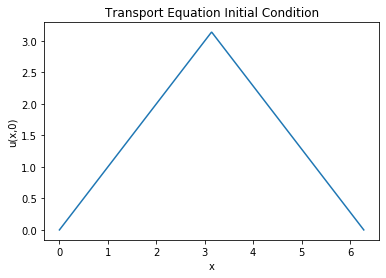

In [4]:
## Define our initial condition here
def f(x):
    x = x % (2*np.pi)
    y= np.piecewise(
        x,
        [(0 <= x)&(x <= np.pi),  (np.pi < x)&(x < 2*np.pi)     ],
        [lambda x: x, lambda x: 2*np.pi - x,0])
    return y

#define stepsizes up here
h = 0.5**np.array([5,6,7])
q = np.linspace(start=0, stop = 2*np.pi, num = int(2*np.pi/h[2]))

plt.plot(q,f(q))
#self explanatory
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.title('Transport Equation Initial Condition')

In [5]:
#Function that allows us to use the different methods to solve the transport equation

In [6]:
# Function that stores different methods on how to solve 1D transport equation
def Transport_Equation(h,l,x0,xN,tK,method):
    '''
    MODEL PARAMETERS:
        h - step size in space
        l - specifies relationship between stepsizes (i.e l = k/h)
        c - speed of the wave
        x0,xN -  is the boundary for space variable
        tK - boundaries for time variable
        eta - diffusive coefficient
        f- our initial condition u(x,0)=f(x)
        method - Fully Implicit (Full) or Semi-Implicit (Semi)
    '''    
    ### step size in time
    k = h*l
    
    #sigma values for Lax-Wendroff and Lax-Friedrichs
    sig_w = l/2; sig_f = 1/(2*l)

    ### CALCULATE GRID SPACES
    x = np.linspace(start = x0, stop = xN, num = int( ((xN - x0)/h) ))
    t = np.linspace(start = 0, stop = tK, num = int( (tK /k) ))
    
    #need to round grid space for x
    x = np.around(x,2)
    ### LENGTHS OF GRIDSPACES
    N, K = len(x), len(t)

    #solution
    u = np.zeros( (N,K) )
    #initial data
    u[:,0] = f(x)
    
    #for creating sparse matrices
    o = np.ones(N)

    #which diagonals we want to define our values on for sparse matrix
    diags = (1-N,-1,0,1,N-1); upwind_diag = (1-N,0,1)
    
    #calculations for fully implicit method
    if method =="Upwind":
        A = spdiags( [l*o,(1-l)*o,l*o], upwind_diag, N, N).toarray()
        for j in range(1,K):
            u[:,j] = A.dot(u[:,j-1])
        return u, x
    if method =="Central":
        A = spdiags( [l*o,-l*o, o, l*o,-l*o], diags, N, N).toarray()
        for j in range(1,K):
            u[:,j] = A.dot(u[:,j-1])
        return u, x
    elif method =="Backward":
        A = spdiags([-0.5*l*o,0.5*l*o, o, -0.5*l*o,0.5*l*o], diags, N, N).toarray()
        B = np.linalg.inv(A)
        for j in range(1,K):
            u[:,j] = B.dot(u[:,j-1])
        return u, x
    elif method == "Crank-Nicolson":
        theta = 1/2
        #FOR CONVENIENCE (i.e. so I can still see what's written)
        a = (1-theta)*l/2; b = theta*l/2
        A = spdiags( [-a*o,a*o,o,-a*o,a*o], diags, N, N).toarray()
        B = spdiags( [b*o,-b*o,o,b*o,-b*o],  diags, N, N).toarray()
        C = np.matmul(np.linalg.inv(A),B)
        for j in range(1,K):
            u[:,j] = C.dot(u[:,j-1])
        return u, x
    elif method == "Lax-Wendroff":
        a, b, c = (sig_w*l- l/2), (1-2*sig_w*l), (sig_w*l+ l/2)
        A = spdiags( [c*o,a*o, b*o, c*o,a*o], diags, N, N).toarray()
        for j in range(1,K):
            u[:,j] = A.dot(u[:,j-1])
        return u, x
    elif method == "Lax-Friedrichs":
        a, b, c = (sig_f*l- l/2), (1-2*sig_f*l), (sig_f*l+ l/2)
        A = spdiags( [c*o,a*o, b*o, c*o,a*o], diags, N, N).toarray()
        for j in range(1,K):
            u[:,j] = A.dot(u[:,j-1])
        return u, x

Text(0.5, 1.0, 'Analytic Solution for Transport Equation')

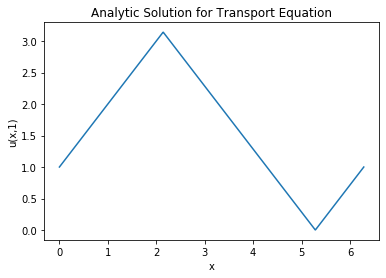

In [7]:
### Theoretical soln
def u(x,t):
    #let's us define a piecewise function
    tau = 2*np.pi
    z = x+t
    z = z % tau
    y= np.piecewise(
        z,
        [(0 <= z)&(z <= np.pi),  (np.pi <= z)&(z <= 2*np.pi)     ],
        [lambda z: z, lambda z: 2*np.pi - (z), 0])
    return y

q = np.linspace(start=0, stop = 2*np.pi, num = int(2*np.pi/h[2]))
plt.plot(q,u(q,1))
plt.xlabel('x')
plt.ylabel('u(x,1)')
plt.title('Analytic Solution for Transport Equation')


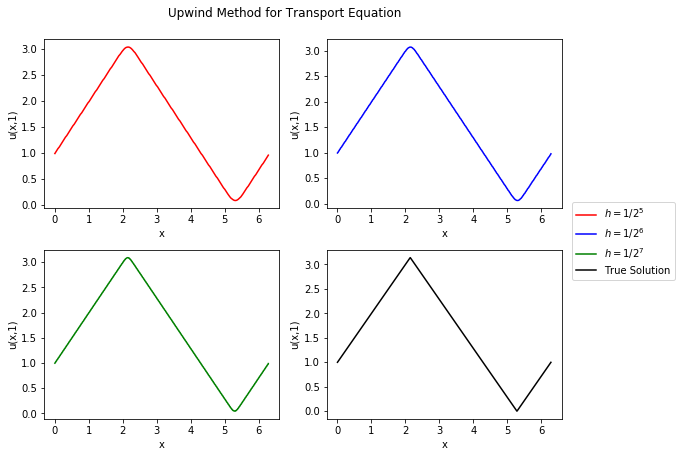

In [8]:
### Upwind Method
u_UM1 = Transport_Equation(h=h[0],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Upwind")
u_UM2 = Transport_Equation(h=h[1],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Upwind")
u_UM3 = Transport_Equation(h=h[2],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Upwind")

fig, axs = plt.subplots(2, 2,figsize=(8,6))
axs[0, 0].plot(u_UM1[1], u_UM1[0][:,-1],color='r', label=f'$h = 1/2^{5}$')
axs[0, 0].set(xlabel="x", ylabel="u(x,1)")

axs[0, 1].plot(u_UM2[1], u_UM2[0][:,-1],color='b', label=f'$h = 1/2^{6}$')
axs[0, 1].set(xlabel="x", ylabel="u(x,1)")

axs[1, 0].plot(u_UM3[1], u_UM3[0][:,-1],color='g',label = f'$h = 1/2^{7}$' )
axs[1, 0].set(xlabel="x", ylabel="u(x,1)")

axs[1, 1].plot(q, u(q,1),color='black',label='True Solution')
axs[1, 1].set(xlabel="x", ylabel="u(x,1)")

fig.legend(bbox_to_anchor=(1.18,0.5),loc='center right')
fig.suptitle('Upwind Method for Transport Equation', y = 1.05)
fig.tight_layout()

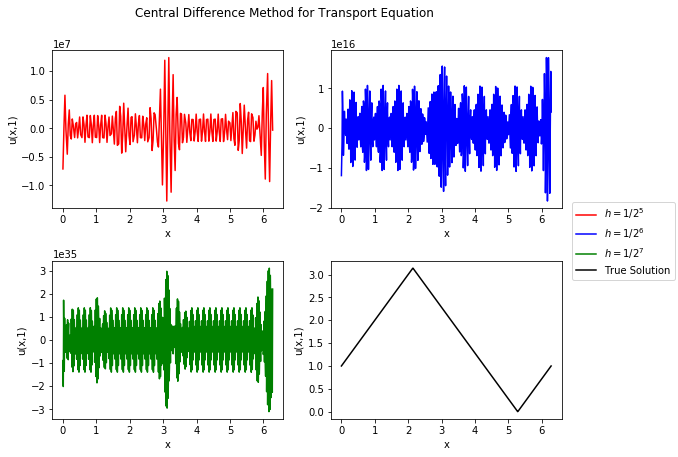

In [9]:
#Central Difference Method
u_CM1 = Transport_Equation(h=h[0],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Central")
u_CM2 = Transport_Equation(h=h[1],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Central")
u_CM3 = Transport_Equation(h=h[2],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Central")

fig, axs = plt.subplots(2, 2,figsize=(8,6))
axs[0, 0].plot(u_CM1[1], u_CM1[0][:,-1],color='r', label=f'$h = 1/2^{5}$')
axs[0, 0].set(xlabel="x", ylabel="u(x,1)")

axs[0, 1].plot(u_CM2[1], u_CM2[0][:,-1],color='b', label=f'$h = 1/2^{6}$')
axs[0, 1].set(xlabel="x", ylabel="u(x,1)")

axs[1, 0].plot(u_CM3[1], u_CM3[0][:,-1],color='g',label = f'$h = 1/2^{7}$' )
axs[1, 0].set(xlabel="x", ylabel="u(x,1)")

axs[1, 1].plot(q, u(q,1),color='black',label="True Solution")
axs[1, 1].set(xlabel="x", ylabel="u(x,1)")

fig.legend(bbox_to_anchor=(1.18,0.5),loc='center right')
fig.suptitle('Central Difference Method for Transport Equation', y = 1.05)
fig.tight_layout()

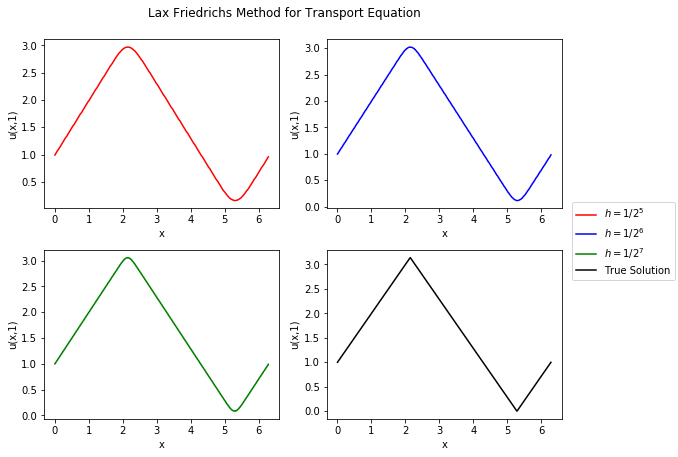

In [10]:
#Lax Friedrichs Scheme
u_LF1 = Transport_Equation(h=h[0],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Lax-Friedrichs")
u_LF2 = Transport_Equation(h=h[1],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Lax-Friedrichs")
u_LF3 = Transport_Equation(h=h[2],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Lax-Friedrichs")

fig, axs = plt.subplots(2, 2,figsize=(8,6))
axs[0, 0].plot(u_LF1[1], u_LF1[0][:,-1],color='r', label=f'$h = 1/2^{5}$')
axs[0, 0].set(xlabel="x", ylabel="u(x,1)")

axs[0, 1].plot(u_LF2[1], u_LF2[0][:,-1],color='b', label=f'$h = 1/2^{6}$')
axs[0, 1].set(xlabel="x", ylabel="u(x,1)")

axs[1, 0].plot(u_LF3[1], u_LF3[0][:,-1],color='g',label = f'$h = 1/2^{7}$' )
axs[1, 0].set(xlabel="x", ylabel="u(x,1)")

axs[1, 1].plot(q, u(q,1),color='black',label="True Solution")
axs[1, 1].set(xlabel="x", ylabel="u(x,1)")

fig.legend(bbox_to_anchor=(1.18,0.5),loc='center right')
fig.suptitle('Lax Friedrichs Method for Transport Equation', y = 1.05)
fig.tight_layout()

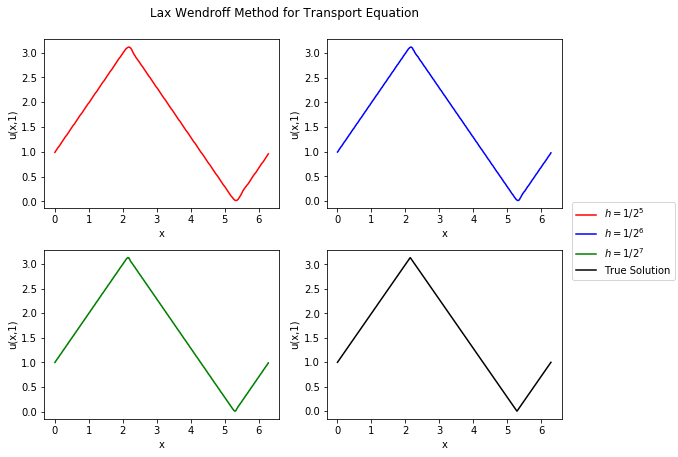

In [11]:
#Lax-Wendroff Scheme
u_LW1 = Transport_Equation(h=h[0],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Lax-Wendroff")
u_LW2 = Transport_Equation(h=h[1],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Lax-Wendroff")
u_LW3 = Transport_Equation(h=h[2],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Lax-Wendroff")

fig, axs = plt.subplots(2, 2,figsize=(8,6))
axs[0, 0].plot(u_LW1[1], u_LW1[0][:,-1],color='r', label=f'$h = 1/2^{5}$')
axs[0, 0].set(xlabel="x", ylabel="u(x,1)")

axs[0, 1].plot(u_LW2[1], u_LW2[0][:,-1],color='b', label=f'$h = 1/2^{6}$')
axs[0, 1].set(xlabel="x", ylabel="u(x,1)")

axs[1, 0].plot(u_LW3[1], u_LW3[0][:,-1],color='g',label = f'$h = 1/2^{7}$' )
axs[1, 0].set(xlabel="x", ylabel="u(x,1)")

axs[1, 1].plot(q, u(q,1),color='black',label="True Solution")
axs[1, 1].set(xlabel="x", ylabel="u(x,1)")

fig.legend(bbox_to_anchor=(1.18,0.5),loc='center right')
fig.suptitle('Lax Wendroff Method for Transport Equation', y= 1.05)
fig.tight_layout()

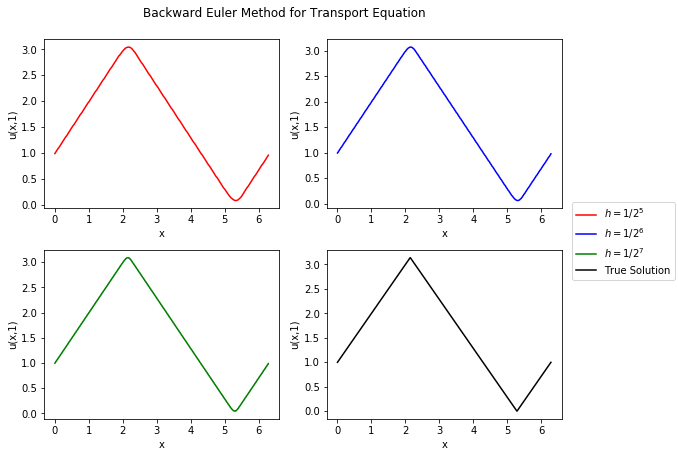

In [12]:
#Backwards Euler Scheme
u_BM1 = Transport_Equation(h=h[0],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Backward")
u_BM2 = Transport_Equation(h=h[1],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Backward")
u_BM3 = Transport_Equation(h=h[2],l=0.5,x0=0,xN=2*np.pi,tK=1,method = "Backward")

fig, axs = plt.subplots(2, 2,figsize=(8,6))
axs[0, 0].plot(u_BM1[1], u_BM1[0][:,-1],color='r', label=f'$h = 1/2^{5}$')
axs[0, 0].set(xlabel="x", ylabel="u(x,1)")

axs[0, 1].plot(u_BM2[1], u_BM2[0][:,-1],color='b', label=f'$h = 1/2^{6}$')
axs[0, 1].set(xlabel="x", ylabel="u(x,1)")

axs[1, 0].plot(u_BM3[1], u_BM3[0][:,-1],color='g',label = f'$h = 1/2^{7}$' )
axs[1, 0].set(xlabel="x", ylabel="u(x,1)")

axs[1, 1].plot(q, u(q,1),color='black',label="True Solution")
axs[1, 1].set(xlabel="x", ylabel="u(x,1)")

fig.legend(bbox_to_anchor=(1.18,0.5),loc='center right')
fig.suptitle('Backward Euler Method for Transport Equation',y = 1.05)
fig.tight_layout()

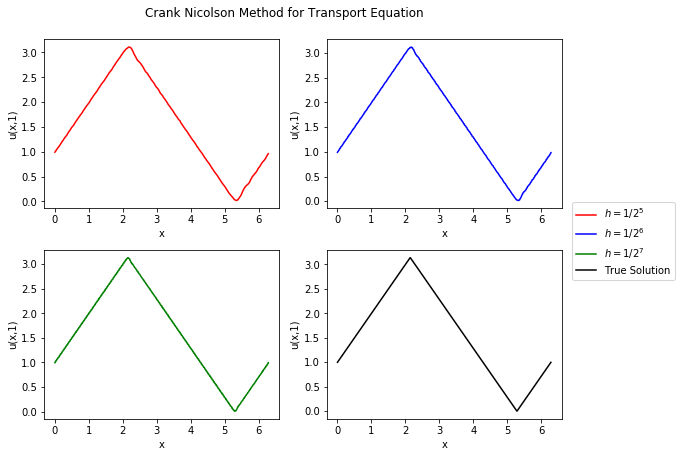

In [13]:
#Crank Nicolson Scheme
u_CN1 = Transport_Equation(h=h[0],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Crank-Nicolson")
u_CN2 = Transport_Equation(h=h[1],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Crank-Nicolson")
u_CN3 = Transport_Equation(h=h[2],l=0.5,x0=0,xN=2*np.pi,tK=1,
                           method = "Crank-Nicolson")

fig, axs = plt.subplots(2, 2,figsize=(8,6))
axs[0, 0].plot(u_CN1[1], u_CN1[0][:,-1],color='r', label=f'$h = 1/2^{5}$')
axs[0, 0].set(xlabel="x", ylabel="u(x,1)")

axs[0, 1].plot(u_CN2[1], u_CN2[0][:,-1],color='b', label=f'$h = 1/2^{6}$')
axs[0, 1].set(xlabel="x", ylabel="u(x,1)")

axs[1, 0].plot(u_CN3[1], u_CN3[0][:,-1],color='g',label = f'$h = 1/2^{7}$' )
axs[1, 0].set(xlabel="x", ylabel="u(x,1)")

axs[1, 1].plot(q, u(q,1),color='black',label="True Solution")
axs[1, 1].set(xlabel="x", ylabel="u(x,1)")

fig.legend(bbox_to_anchor=(1.18,0.5),loc='center right')
fig.suptitle('Crank Nicolson Method for Transport Equation', y = 1.05)
fig.tight_layout()

In [15]:
### Error calculations in h norm
def h_norm(x,h):
    '''
    PARAMETERS:
        x - vector we're taking the norm of
        h - step size wrt x
    '''
    return np.sqrt(np.dot(x, x) * h)

print(f"The Upwind Method error is {h_norm(u_UM3[0][:,-1]-u(q,1),h[2])}")
print(f"The Central Difference Method error is {h_norm(u_CM3[0][:,-1]-u(q,1),h[2])}")
print(f"The Lax-Friedrichs Method error is {h_norm(u_LF3[0][:,-1]-u(q,1),h[2])}")
print(f"The Lax-Wendroff Method error is {h_norm(u_LW3[0][:,-1]-u(q,1),h[2])}")
print(f"The Backwards Euler Method error is {h_norm(u_BM3[0][:,-1]-u(q,1),h[2])}")
print(f"The Crank-Nicolson Method error is {h_norm(u_CN3[0][:,-1]-u(q,1),h[2])}")

The Upwind Method error is 0.017654362543994252
The Central Difference Method error is 2.1963759879817847e+35
The Lax-Friedrichs Method error is 0.033864693873646726
The Lax-Wendroff Method error is 0.01248398094789808
The Backwards Euler Method error is 0.017888445695970492
The Crank-Nicolson Method error is 0.014923217652392094
